In [1]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch, os
from torch.utils.data import Dataset
from ipywidgets import interact 
import seaborn as sns
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import tensorflow as tf
import numpy as np

In [2]:
torch.__version__

'2.1.0+cpu'

# Loading Data

In [3]:
train_df, test_df = pd.read_csv('seed.csv'), pd.read_csv('test.csv')

In [4]:
train_df

,example,label
0,Seller: Hello Buyer: Wow love the Couch. SO lo...,furniture
1,Seller: I am selling this for $28500. Buyer: I...,car
2,Buyer: I'd like to negotiate a lower price for...,housing
3,Seller: Hi! Are you interested in my headphon...,electronics
4,Seller: Hi. Were you interested in the mirror?...,furniture
...,...,...
195,Buyer: Hi! Beautiful car.. Seller: Thank you ...,car
196,Buyer: I would love to have the phone. I can g...,phone
197,"Buyer: Hello, I'm interested in the bike Selle...",bike
198,"Seller: Hi, are you calling about the desk? Bu...",furniture


In [10]:
test_df['label'].skew()

TypeError: could not convert string to float: 'furniture'

In [5]:
test_df.shape

(1000, 2)

In [6]:
from sklearn.model_selection import train_test_split
initial_labeled_set, pool = train_test_split(train_df, test_size=0.95, stratify=train_df['label'])

In [7]:
num_labels = 6
id_to_label = {id : label for id, label in enumerate(initial_labeled_set.label.unique())}
label_to_id = {label : id  for id, label in enumerate(initial_labeled_set.label.unique())}

In [8]:
train_df['label']= train_df['label'].map(label_to_id)
test_df['label'] = test_df['label'].map(label_to_id)

# Spliting Data into train_encodings, test_encodings

In [9]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)

In [10]:
train_encodings = tokenizer(train_df['example'].to_list(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['example'].to_list(), truncation=True, padding=True)
train_labels = train_df.label.to_list()
test_labels = test_df.label.to_list()

In [11]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, id2label = id_to_label, label2id = label_to_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### TrainingArguments, Dataloader, Metrics are needed to construct this Fine-tune the model

In [12]:
training_args = TrainingArguments(
    output_dir='./BERTModel2',
    do_train=True,
    do_eval=True,
    num_train_epochs=3,  # Reduced number of epochs.
    per_device_train_batch_size=5,  # Reduced batch size for training.
    per_device_eval_batch_size=20,  # Reduced batch size for evaluation.
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=True,  # Enable mixed precision training.
)


In [14]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        """
          This construct a dict that is (index position) to encoding pairs.
          Where the Encoding becomes tensor(Encoding), which is an requirements
          for training the model
        """
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        """
        Returns the number of data items in the dataset.

        """
        return len(self.labels)

In [15]:
def compute_metrics(pred):
    
   
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro',zero_division=1)

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

# Calling our Dataloader

In [16]:
train_dataloader = DataLoader(train_encodings,train_labels)
test_dataloader = DataLoader(test_encodings,test_labels)

In [17]:
trainer = Trainer(
    #the pre-trained bert model that will be fine-tuned
    model=model,
    #training arguments that we defined above
    args=training_args,
    train_dataset= train_dataloader,
    eval_dataset = test_dataloader,
    compute_metrics= compute_metrics
)

#  Evaluate the prediction accuracy of our model on the dataset without training or fine-tuning it

In [18]:
predictions = trainer.predict(test_dataloader)


  0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
predicted_labels = predictions.predictions.argmax(axis=1)


In [20]:
accuracy = accuracy_score(test_df['label'].to_list(),predicted_labels)
print('accuracy {}% '.format(np.round(accuracy * 100)))

accuracy 20.0% 


## An Active Learning Approach Based On Uncertain Sampling

In [21]:
initial_labeled_set.head() # so we fine_tune with the inital_labeled data

,example,label
5,Buyer: i'm very interested in the apt. Seller...,housing
69,"Buyer: Hello, I am interested in your couch. W...",furniture
135,"Seller: hi, you like mountain biking? Buyer: I...",bike
193,"Seller: Buyer: Hello, I am interested in the ...",furniture
118,"Buyer: Wow, this looks like a great car. I'm i...",car


In [22]:
initial_labeled_set.shape

(10, 2)

# 

In [23]:
def entropy_for_each_row(class_probabilities):
    """ Calculate entropy for each row in the array """
    return -tf.reduce_sum(class_probabilities * tf.math.log(class_probabilities),axis=1)

In [24]:
def predict_and_calculate_entropy(data):
    
    ''' 
    Predict and Calculate Entropy
    
    This function makes predictions using a pre-trained BERT model, calculates the entropy (uncertainty) of these predictions, 
    and creates a DataFrame containing relevant information.
    
    Args:
        data (DataFrame): A Pandas DataFrame containing text data and associated labels. The DataFrame should have 
        columns 'example' for text data and 'label' for labels.

    Returns:
        final_df (DataFrame): A Pandas DataFrame containing the following columns:
            - 'example': The original text data.
            - 'predicted_Label': The predicted class labels based on the model's predictions.
            - 'predicted_Probability': The maximum predicted probability for each instance.
            - 'Entropy': The calculated entropy (uncertainty) for each instance.
            - 'label': The original labels from the input data.
    ''' 

    
            
    # Sample the Data 
    data_encodings = tokenizer(data['example'].to_list(), truncation=True, padding=True)
    dataloader = DataLoader(data_encodings, data.label.to_list())

    # Make predictions with class_probabilities and calculate entropy (uncertainty) 
    predictions = trainer.predict(dataloader)
    prediction_probabilities = tf.constant(predictions.predictions)

    # Predicted Labels 
    predicted_labels = predictions.predictions.argmax(axis=1)

    
    # Prediction probabilities, returning the highest probability for each instance
    prediction_probabilities_max = np.amax(prediction_probabilities, axis=1)

    # Calculate entropy for each instance
    entropies = entropy_for_each_row(tf.nn.softmax(prediction_probabilities))

    entropy_df = pd.DataFrame(
        {'example' : data['example'].to_list(),
         'predicted_Label': predicted_labels,
         'predicted_Probability': prediction_probabilities_max,
         'Entropy': entropies},
        index=data.index
    )

    final_df = pd.concat([data['label'], entropy_df], axis=1)

    return final_df.sort_values(by=['Entropy'],ascending=False)


In [25]:
test_df['label'].skew()

0.48646658670510623

# Simulated Active Learning

In [26]:
initial_labeled_set2 = test_df.head(150)

In [27]:
initial_labeled_set2

,example,label
0,Seller: Hi are you interested in buying my Pin...,1
1,Buyer: Hello I am interested in your property ...,0
2,Buyer: Hello . How long have you owned the dre...,1
3,Buyer: I am very interested place you have for...,0
4,"Buyer: Hey, nice car you have here, how long h...",3
...,...,...
145,"Buyer: So, what's wrong with this phone? Selle...",5
146,"Buyer: Hi, how many miles does this car have? ...",3
147,Buyer: Hi there. I'm interested in your bicycl...,2
148,Buyer: Is there any scratches or stains on the...,1


In [28]:
hundreds_rows_pred = predict_and_calculate_entropy(initial_labeled_set2)

  0%|          | 0/8 [00:00<?, ?it/s]

In [29]:
hundreds_rows_pred

,label,example,predicted_Label,predicted_Probability,Entropy
35,5,"Buyer: Hello, Seller: dublin? Buyer: No not at...",0,0.334229,1.770058
22,1,Buyer: I'd like to buy the table. Considering ...,0,0.341309,1.762777
36,2,"Buyer: Hi, I am interested in the item you hav...",0,0.443848,1.762157
142,0,"Buyer: hi , i am wondering if you could tell m...",0,0.356689,1.761884
90,1,Seller: hello can I help you? Buyer: I'm inter...,0,0.366943,1.761322
...,...,...,...,...,...
12,0,Seller: So does 3000 sound like a reasonable p...,5,0.468750,1.735614
16,1,Buyer: Hello Seller: Are you interested in the...,1,0.393799,1.735163
112,2,"Seller: hi, i saw your note about this listing...",5,0.443848,1.734422
56,4,Seller: Hi are you interested? Buyer: Yes but ...,0,0.412598,1.733789


# Active Learning

In [30]:
# Initialize empty lists to store metrics for each iteration
accuracy_list = []
precision_list = []
recall_list = []
loss_list = []
x_labels = []
n = 0

for iteration in range(15):
    n += 10
    print(n)
    initial_labeled_encoding = tokenizer(hundreds_rows_pred[0:n]['example'].to_list(), truncation=True, padding=True)
    initial_labeled_labels = hundreds_rows_pred[0:n].label.to_list()
    initial_labeled_dataloader = DataLoader(initial_labeled_encoding,initial_labeled_labels)

   
    trainer = Trainer(
        #the pre-trained bert model that will be fine-tuned
        model=model,
        #training arguments that we defined above
        args=training_args,
        train_dataset= initial_labeled_dataloader,
        eval_dataset = test_dataloader,
        compute_metrics= compute_metrics
    )

    trainer.train()

    metrics = trainer.evaluate()

    print('eval_Accuracy :',metrics['eval_Accuracy'])

    accuracy_list.append(metrics['eval_Accuracy'])
    precision_list.append(metrics['eval_Precision'])
    recall_list.append(metrics['eval_Recall'])
    loss_list.append(metrics['eval_loss'])
    x_labels.append(n)



10


  0%|          | 0/6 [00:00<?, ?it/s]

{'train_runtime': 1.8413, 'train_samples_per_second': 16.293, 'train_steps_per_second': 3.259, 'train_loss': 1.7073893547058105, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.2
20


  0%|          | 0/12 [00:00<?, ?it/s]

{'train_runtime': 2.4111, 'train_samples_per_second': 24.885, 'train_steps_per_second': 4.977, 'train_loss': 1.827067216237386, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.293
30


  0%|          | 0/18 [00:00<?, ?it/s]

{'train_runtime': 3.6279, 'train_samples_per_second': 24.807, 'train_steps_per_second': 4.961, 'train_loss': 1.7530163658989801, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.249
40


  0%|          | 0/24 [00:00<?, ?it/s]

{'train_runtime': 4.8528, 'train_samples_per_second': 24.728, 'train_steps_per_second': 4.946, 'train_loss': 1.583215554555257, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.371
50


  0%|          | 0/30 [00:00<?, ?it/s]

{'train_runtime': 6.1764, 'train_samples_per_second': 24.286, 'train_steps_per_second': 4.857, 'train_loss': 1.3936261494954427, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.414
60


  0%|          | 0/36 [00:00<?, ?it/s]

{'train_runtime': 7.3706, 'train_samples_per_second': 24.422, 'train_steps_per_second': 4.884, 'train_loss': 1.2276584837171767, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.6
70


  0%|          | 0/42 [00:00<?, ?it/s]

{'train_runtime': 8.617, 'train_samples_per_second': 24.37, 'train_steps_per_second': 4.874, 'train_loss': 0.9751464298793248, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.73
80


  0%|          | 0/48 [00:00<?, ?it/s]

{'train_runtime': 9.6817, 'train_samples_per_second': 24.789, 'train_steps_per_second': 4.958, 'train_loss': 0.7011230786641439, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.782
90


  0%|          | 0/54 [00:00<?, ?it/s]

{'loss': 0.3992, 'learning_rate': 2.4e-05, 'epoch': 2.78}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.4243875741958618, 'eval_Accuracy': 0.9, 'eval_F1': 0.8838235070440182, 'eval_Precision': 0.904170863879579, 'eval_Recall': 0.8753076617185472, 'eval_runtime': 13.7212, 'eval_samples_per_second': 72.88, 'eval_steps_per_second': 3.644, 'epoch': 2.78}
{'train_runtime': 24.4969, 'train_samples_per_second': 11.022, 'train_steps_per_second': 2.204, 'train_loss': 0.3811280572855914, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.91
100


  0%|          | 0/60 [00:00<?, ?it/s]

{'loss': 0.1741, 'learning_rate': 2.45e-05, 'epoch': 2.5}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.321381539106369, 'eval_Accuracy': 0.913, 'eval_F1': 0.9021624225386927, 'eval_Precision': 0.9045260852297115, 'eval_Recall': 0.9012476912138975, 'eval_runtime': 13.7994, 'eval_samples_per_second': 72.467, 'eval_steps_per_second': 3.623, 'epoch': 2.5}
{'train_runtime': 25.8295, 'train_samples_per_second': 11.615, 'train_steps_per_second': 2.323, 'train_loss': 0.15964271227518717, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.916
110


  0%|          | 0/66 [00:00<?, ?it/s]

{'loss': 0.0485, 'learning_rate': 2.45e-05, 'epoch': 2.27}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.34754157066345215, 'eval_Accuracy': 0.909, 'eval_F1': 0.8975985119056924, 'eval_Precision': 0.9103325525760092, 'eval_Recall': 0.8875059547148006, 'eval_runtime': 13.794, 'eval_samples_per_second': 72.495, 'eval_steps_per_second': 3.625, 'epoch': 2.27}
{'train_runtime': 27.1115, 'train_samples_per_second': 12.172, 'train_steps_per_second': 2.434, 'train_loss': 0.04135174462289521, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.914
120


  0%|          | 0/72 [00:00<?, ?it/s]

{'loss': 0.0588, 'learning_rate': 2.4e-05, 'epoch': 2.08}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.4452742338180542, 'eval_Accuracy': 0.908, 'eval_F1': 0.9009946914636102, 'eval_Precision': 0.9085923684425706, 'eval_Recall': 0.904036848001961, 'eval_runtime': 13.8454, 'eval_samples_per_second': 72.226, 'eval_steps_per_second': 3.611, 'epoch': 2.08}
{'train_runtime': 28.2107, 'train_samples_per_second': 12.761, 'train_steps_per_second': 2.552, 'train_loss': 0.04251510432610909, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.916
130


  0%|          | 0/78 [00:00<?, ?it/s]

{'loss': 0.1039, 'learning_rate': 2.4e-05, 'epoch': 1.92}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.7269527316093445, 'eval_Accuracy': 0.872, 'eval_F1': 0.8518954100199695, 'eval_Precision': 0.897636742886589, 'eval_Recall': 0.8264894834539661, 'eval_runtime': 13.8467, 'eval_samples_per_second': 72.219, 'eval_steps_per_second': 3.611, 'epoch': 1.92}
{'train_runtime': 29.46, 'train_samples_per_second': 13.238, 'train_steps_per_second': 2.648, 'train_loss': 0.08758214039680286, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.915
140


  0%|          | 0/84 [00:00<?, ?it/s]

{'loss': 0.1263, 'learning_rate': 2.4e-05, 'epoch': 1.79}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.5410487055778503, 'eval_Accuracy': 0.897, 'eval_F1': 0.8865061461828158, 'eval_Precision': 0.89673092499116, 'eval_Recall': 0.8814245533364886, 'eval_runtime': 13.8317, 'eval_samples_per_second': 72.298, 'eval_steps_per_second': 3.615, 'epoch': 1.79}
{'train_runtime': 30.6061, 'train_samples_per_second': 13.723, 'train_steps_per_second': 2.745, 'train_loss': 0.09665289521217346, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.919
150


  0%|          | 0/90 [00:00<?, ?it/s]

{'loss': 0.0702, 'learning_rate': 2.45e-05, 'epoch': 1.67}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.45140600204467773, 'eval_Accuracy': 0.905, 'eval_F1': 0.8802568498957508, 'eval_Precision': 0.8780868163447032, 'eval_Recall': 0.8899780549418397, 'eval_runtime': 13.857, 'eval_samples_per_second': 72.166, 'eval_steps_per_second': 3.608, 'epoch': 1.67}
{'train_runtime': 31.8503, 'train_samples_per_second': 14.129, 'train_steps_per_second': 2.826, 'train_loss': 0.06898058255513509, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.92


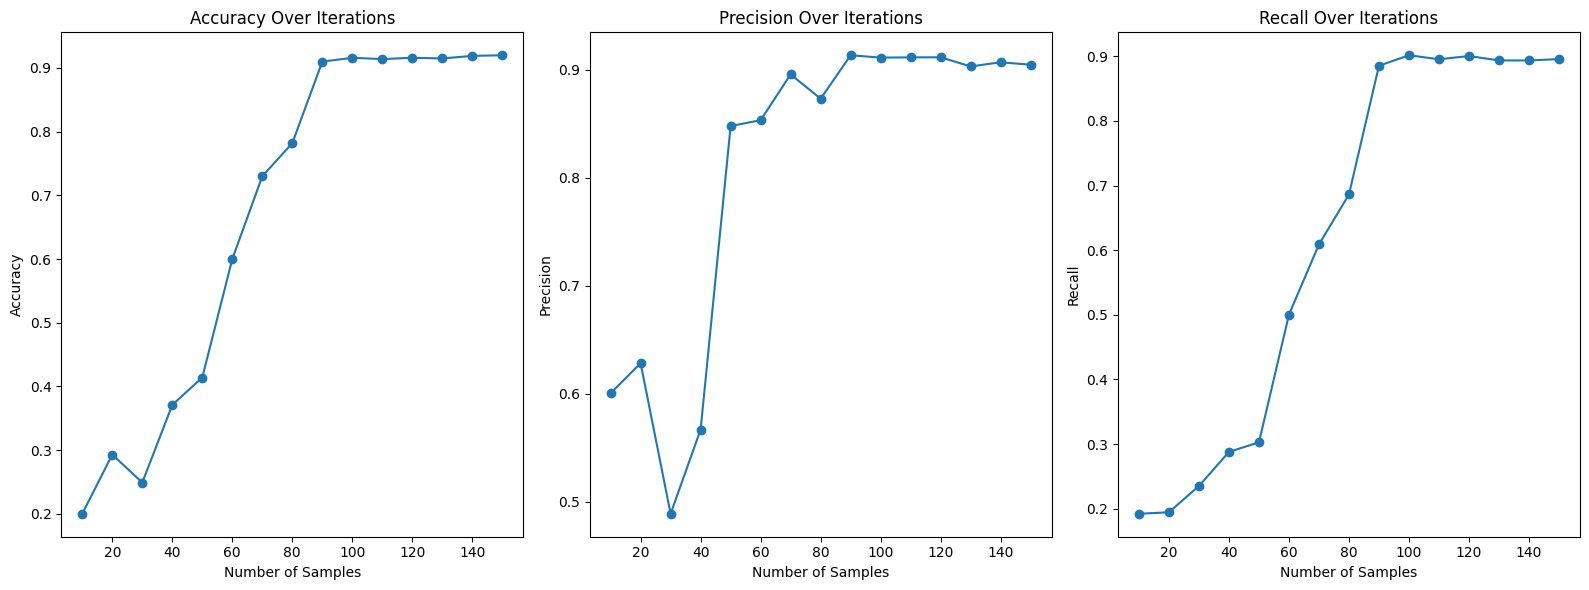

In [31]:
# Plot the metrics
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.plot(x_labels, accuracy_list, marker='o')
plt.title('Accuracy Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(x_labels, precision_list, marker='o')
plt.title('Precision Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Precision')

plt.subplot(1, 3, 3)
plt.plot(x_labels, recall_list, marker='o')
plt.title('Recall Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()

In [32]:
predictions = trainer.predict(test_dataloader)
predicted_labels = predictions.predictions.argmax(axis=1)
accuracy = accuracy_score(test_df['label'].to_list(),predicted_labels)
print('accuracy {}% '.format(np.round(accuracy * 100)))


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 92.0% 


In [33]:
bert_pred_df = pd.DataFrame({'Bert_Pred' : predicted_labels, 'Label' : test_df['label'].to_list() })

In [34]:
bert_pred_df.to_csv('Craigslist_Bert_Pred.csv',index=False)

In [35]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix

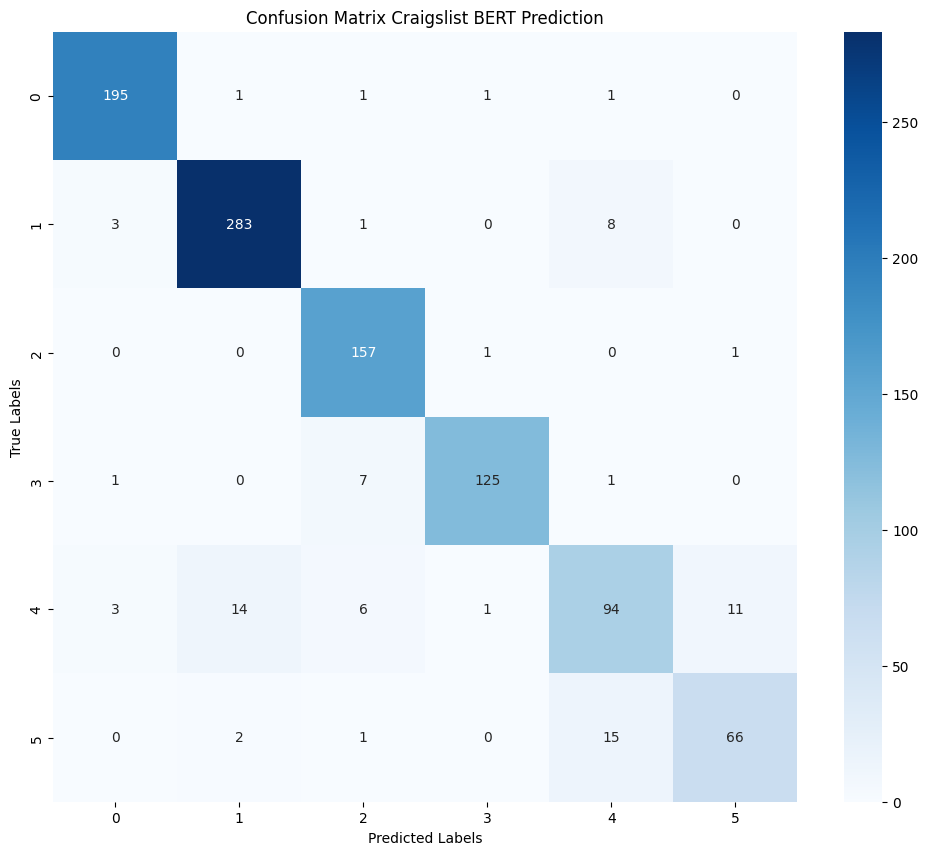

In [36]:
# Compute the confusion matrix
cm = confusion_matrix(test_df['label'].to_list(),predicted_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Craigslist BERT Prediction')


# Save the confusion matrix as an image
plt.savefig('confusion_matrix.png')
plt.show()

In [38]:
import csv


# Combine the lists into a list of tuples
data = list(zip(x_labels, accuracy_list, precision_list, recall_list, loss_list))

# Specify the file name
csv_file_name = "Crag_Label_Accuracies.csv"

# Write the data to a CSV file
with open(csv_file_name, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    
    csv_writer.writerow(['Labels', 'accuracy', 'precision', 'recall', 'loss'])
    
    # Write the data
    csv_writer.writerows(data)

print(f"CSV file '{csv_file_name}' has been created.")

CSV file 'Crag_Label_Accuracies.csv.csv' has been created.
